In [10]:
import os
import git
import sys
from joblib import Parallel, delayed

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

from abm_vec.abm_simulation import run_simulation
from abm_vec.initialization import get_bank_data
from scipy.optimize import minimize
from scipy.stats import kstest
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials import get_git_root_directory
import numpy as np
import random
from scipy import stats

In [2]:
bank_data = get_bank_data()

# Minimize the KS distance first

In [3]:
def fun(x):

    param = {'firm_lb1': x[0],
             'firm_lb2': x[1],
             'firm_ub1': x[2],
             'firm_ub2': x[3],
             'firm_alpha1': x[4],
             'firm_alpha2': x[5],
             'firm_rho': x[6],
             'min_productivity': x[7],
             'market_price': x[8]}
    results = run_simulation(1, copy.deepcopy(bank_data), param) 
    max_diff = kstest(results[0], results[1], alternative='two-sided').statistic 
    return max_diff

In [4]:
bounds = [(5 * 10 ** 5, 5 * 10 ** 6),
          (10 ** 3, 10**4),
          (5 * 10** 7, 30 * 10 ** 7),
          (5 * 10 ** 5, 10 ** 7),
          (0, 3),
          (0, 3),
          (0, 1) ,
          (100, 1000),
          (50, 2000)]

initial_guess = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150, 820]


result = minimize(fun, initial_guess, method='Nelder-Mead', bounds=bounds)

In [5]:
optimal_x = result.x

In [24]:
optimal_x

array([9.85306867e+05, 7.80304587e+03, 1.51534168e+08, 7.02465046e+05,
       1.66464979e+00, 1.66480151e+00, 9.36365504e-01, 1.40908624e+02,
       8.16166428e+02])

# Generate 1000 samples and apply the k-sample Anderson test

In [15]:
def fun(seed=1, bank_data=None):

    param = {'firm_lb1': optimal_x[0],
             'firm_lb2': optimal_x[1],
             'firm_ub1': optimal_x[2],
             'firm_ub2': optimal_x[3],
             'firm_alpha1': optimal_x[4],
             'firm_alpha2': optimal_x[5],
             'firm_rho': optimal_x[6],
             'min_productivity': optimal_x[7],
             'market_price': optimal_x[8]}
    e, s = run_simulation(seed, copy.deepcopy(bank_data), param)
    return e, s


random_seeds = random.sample(range(1, 100000), 1000)

results = Parallel(n_jobs=-1)(delayed(fun)(i, bank_data) for i in random_seeds)

In [ ]:
# Anderson k-sample test

In [17]:
from scipy.stats import anderson_ksamp

In [18]:
res = anderson_ksamp([x[1] for x in results])

/tmp/ipykernel_2884/222184903.py:1: UserWarning: p-value capped: true value larger than 0.25
  res = anderson_ksamp([x[1] for x in results])


In [19]:
res.pvalue

0.25

In [20]:
git_root = get_git_root_directory()
plot_dir = git_root + '/plots/'

# Apply the Ks test for each simulation and look at p-value

In [21]:
# ks test
res = [kstest(r[0], r[1], alternative='two-sided').pvalue for r in results]

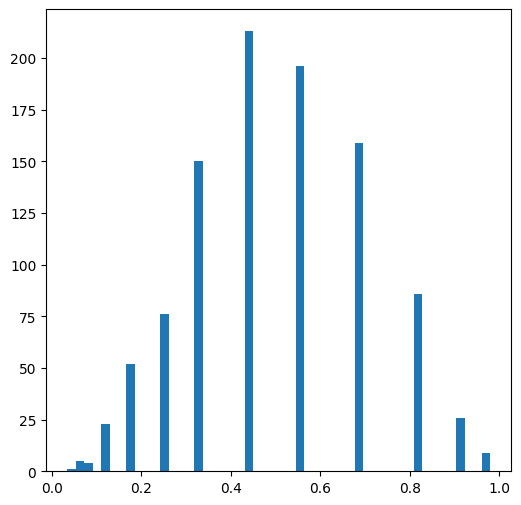

In [23]:
fig = plt.figure(figsize=(6, 6))
plt.hist(res, bins=50)
fig.savefig(plot_dir + "p_value_distr.png", dpi=300)
plt.show()

# Look at defaulting firms now

In [3]:
optimal_x = np.array([9.85306867e+05, 7.80304587e+03, 1.51534168e+08, 7.02465046e+05,
       1.66464979e+00, 1.66480151e+00, 9.36365504e-01, 1.40908624e+02,
       8.16166428e+02])

In [4]:
param = {'firm_lb1': optimal_x[0],
             'firm_lb2': optimal_x[1],
             'firm_ub1': optimal_x[2],
             'firm_ub2': optimal_x[3],
             'firm_alpha1': optimal_x[4],
             'firm_alpha2': optimal_x[5],
             'firm_rho': optimal_x[6],
             'min_productivity': optimal_x[7],
             'market_price': optimal_x[8],
         'good_consumption_std': [0.002, 0.002]
        }

In [29]:
consumption_level = np.linspace(0, 0.6, 1)

In [31]:
results = []
for c in consumption_level:
    break
    random_seeds = random.sample(range(1, 100000), 1000)
    p = copy.deepcopy(param)
    p['good_consumption'] = [c, c]
    res = Parallel(n_jobs=-1)(delayed(run_simulation)(i, copy.deepcopy(bank_data), p)  for i in random_seeds)
    results.append(res)

In [27]:
p = copy.deepcopy(param)
p['good_consumption'] = [c, c]

In [33]:
p

{'firm_lb1': 985306.867,
 'firm_lb2': 7803.04587,
 'firm_ub1': 151534168.0,
 'firm_ub2': 702465.046,
 'firm_alpha1': 1.66464979,
 'firm_alpha2': 1.66480151,
 'firm_rho': 0.936365504,
 'min_productivity': 140.908624,
 'market_price': 816.166428,
 'good_consumption_std': [0.002, 0.002],
 'good_consumption': [0.4, 0.4]}

In [21]:
firm_default = [x[0] for x in results]
bank_default = [x[1] for x in results]

In [24]:
consumption_level

array([0.4])

In [9]:
confidence = 0.95

In [11]:
f_means = []
f_intervals = []

for data in firm_default:
    # Calculate mean
    mean = np.mean(data)
    f_means.append(mean)
    
    # Calculate the standard error and confidence interval
    stderr = stats.sem(data)
    n = len(data)
    h = stderr * stats.t.ppf((1 + confidence) / 2, n - 1)
    f_intervals.append(h)

In [12]:
f_means = np.array(f_means)
f_intervals = np.array(f_intervals)

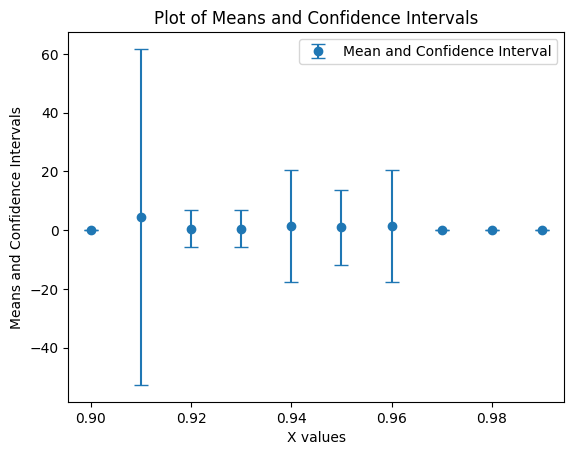

In [13]:
plt.errorbar(consumption_level, f_means, yerr=f_intervals, fmt='o', capsize=5, label='Mean and Confidence Interval')
plt.xlabel('X values')
plt.ylabel('Means and Confidence Intervals')
plt.title('Plot of Means and Confidence Intervals')
plt.legend()
plt.show()

In [18]:
results[-1]

[(0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 2),
 (0, 0),
 (0, 1),
 (0, 2),
 (0, 1),
 (0, 0),
 (0, 2),
 (0, 0),
 (0, 1),
 (0, 2),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 3),
 (0, 1),
 (0, 3),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 2),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 2),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 3),
 (0, 0),
 (0, 2),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 2),
 (0, 3),
 (0, 2),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 2),
 (0, 0),
 (0, 2),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 3),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 0),
 

In [ ]:
plt.plot(consumption_level, firm_default)

In [ ]:
plt.plot(consumption_level, bank_default)